# CardioFusion: Baseline Machine Learning Models

## Project Overview
This notebook implements baseline machine learning models for cardiovascular disease prediction using the preprocessed and balanced dataset from our CardioFusion pipeline.

### Baseline Models
1. Logistic Regression - Linear probabilistic model
2. Decision Tree - Interpretable rule-based model
3. Random Forest - Ensemble tree-based model

### Dataset Information
- Source: Preprocessed CVD_Cleaned.csv (567,606 balanced records)
- Features: 27 engineered and encoded features
- Target: Heart Disease (50% No, 50% Yes after SMOTE)
- Split: 80% Training (454,084), 20% Testing (113,522)

## Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Utilities
import joblib
from datetime import datetime
import os

# Styling
plt.style.use('default')
sns.set_palette("husl")

📚 All libraries imported successfully!
📅 Baseline Models Training Started: 2025-11-19 17:38:43


## Load Preprocessed Data

In [ ]:
# Load the preprocessed training and testing data
import os
from pathlib import Path

# Define paths using new organized structure
data_dir = Path('../data/processed')
models_dir = Path('../models/preprocessing')

train_path = data_dir / 'train_data.csv'
test_path = data_dir / 'test_data.csv'
label_encoder_path = models_dir / 'label_encoder.pkl'
scaler_path = models_dir / 'scaler.pkl'

# Load training and testing data
if not train_path.exists() or not test_path.exists():
    raise FileNotFoundError(
        f"Could not find data files:\n"
        f"   {train_path.absolute()}\n"
        f"   {test_path.absolute()}\n\n"
        "Please run data_preprocessing.ipynb first to generate these files."
    )

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Load preprocessing components
try:
    label_encoder = joblib.load(label_encoder_path)
    scaler = joblib.load(scaler_path)
except FileNotFoundError:
    label_encoder = None
    scaler = None

# Separate features and target
target_col = 'Heart_Disease'
if target_col not in train_data.columns:
    raise ValueError(f"Target column '{target_col}' not found in data!")

X_train = train_data.drop(target_col, axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(target_col, axis=1)
y_test = test_data[target_col]

# Encode target variable if it's categorical (Yes/No to 1/0)
if y_train.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    if label_encoder is None:
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)
    else:
        y_train = label_encoder.transform(y_train)
        y_test = label_encoder.transform(y_test)

# Check class balance
train_dist = pd.Series(y_train).value_counts(normalize=True) * 100
test_dist = pd.Series(y_test).value_counts(normalize=True) * 100

📂 LOADING PREPROCESSED DATA
✅ Found data files in: ../data/processed
✅ Preprocessing components loaded from: ../models/preprocessing
✅ Training data loaded: 454,084 samples, 28 features
✅ Testing data loaded: 113,522 samples, 28 features

📋 PREPARING DATA FOR MODELING
✅ Features (X_train): (454084, 27)
✅ Target (y_train): (454084,)
✅ Features (X_test): (113522, 27)
✅ Target (y_test): (113522,)

🔄 Encoding target variable...
✅ Target encoded: {'No': np.int64(0), 'Yes': np.int64(1)}

⚖️ CLASS DISTRIBUTION
Training: Class 0: 50.0%, Class 1: 50.0%
Testing: Class 0: 50.0%, Class 1: 50.0%

✅ Data ready for model training!
✅ Found data files in: ../data/processed
✅ Preprocessing components loaded from: ../models/preprocessing
✅ Training data loaded: 454,084 samples, 28 features
✅ Testing data loaded: 113,522 samples, 28 features

📋 PREPARING DATA FOR MODELING
✅ Features (X_train): (454084, 27)
✅ Target (y_train): (454084,)
✅ Features (X_test): (113522, 27)
✅ Target (y_test): (113522,)

🔄 Enco

## Model Configuration & Training

In [ ]:
# Configure baseline models
RANDOM_STATE = 42

# Initialize baseline models
models = {
    'Logistic Regression': LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        solver='liblinear'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10
    ),
    'Random Forest': RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=5,
        n_jobs=-1
    )
}

# Dictionary to store trained models and results
trained_models = {}
model_results = {}

🏗️ CONFIGURING BASELINE MODELS
✅ Configured 3 baseline models:
   🤖 Logistic Regression
   🤖 Decision Tree
   🤖 Random Forest

🚀 Starting model training...


## Model Training & Evaluation

In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Store results
    trained_models[model_name] = model
    model_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

🎯 TRAINING & EVALUATING MODELS

🤖 Training Logistic Regression...
   ✅ Accuracy: 0.8394
   ✅ Precision: 0.8481
   ✅ Recall: 0.8270
   ✅ F1-Score: 0.8374
   ✅ ROC-AUC: 0.9261
   ✅ CV Score: 0.8377 ± 0.0016
   ⏱️ Training Time: 4.18s

🤖 Training Decision Tree...
   ✅ Accuracy: 0.8394
   ✅ Precision: 0.8481
   ✅ Recall: 0.8270
   ✅ F1-Score: 0.8374
   ✅ ROC-AUC: 0.9261
   ✅ CV Score: 0.8377 ± 0.0016
   ⏱️ Training Time: 4.18s

🤖 Training Decision Tree...
   ✅ Accuracy: 0.8210
   ✅ Precision: 0.8291
   ✅ Recall: 0.8088
   ✅ F1-Score: 0.8188
   ✅ ROC-AUC: 0.9080
   ✅ CV Score: 0.8197 ± 0.0024
   ⏱️ Training Time: 1.97s

🤖 Training Random Forest...
   ✅ Accuracy: 0.8210
   ✅ Precision: 0.8291
   ✅ Recall: 0.8088
   ✅ F1-Score: 0.8188
   ✅ ROC-AUC: 0.9080
   ✅ CV Score: 0.8197 ± 0.0024
   ⏱️ Training Time: 1.97s

🤖 Training Random Forest...
   ✅ Accuracy: 0.8340
   ✅ Precision: 0.8016
   ✅ Recall: 0.8876
   ✅ F1-Score: 0.8424
   ✅ ROC-AUC: 0.9175
   ✅ CV Score: 0.8331 ± 0.0016
   ⏱️ Training 

## Performance Comparison

In [ ]:
# Create comprehensive performance comparison
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1_score'] for results in model_results.values()],
    'ROC-AUC': [results['roc_auc'] for results in model_results.values()],
    'CV Mean': [results['cv_mean'] for results in model_results.values()],
    'CV Std': [results['cv_std'] for results in model_results.values()],
    'Training Time (s)': [results['training_time'] for results in model_results.values()]
})

# Display results table
print("PERFORMANCE METRICS TABLE")
print(results_df.round(4).to_string(index=False))

# Find best performing model for each metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for metric in metrics:
    best_model = results_df.loc[results_df[metric].idxmax(), 'Model']
    best_score = results_df[metric].max()
    print(f"{metric}: {best_model} ({best_score:.4f})")

# Overall best model (based on F1-score as it balances precision and recall)
best_overall = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
print(f"OVERALL BEST MODEL (F1-Score): {best_overall}")

📊 BASELINE MODELS PERFORMANCE COMPARISON

📋 PERFORMANCE METRICS TABLE
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  CV Mean  CV Std  Training Time (s)
Logistic Regression    0.8394     0.8481  0.8270    0.8374   0.9261   0.8377  0.0016             4.1786
      Decision Tree    0.8210     0.8291  0.8088    0.8188   0.9080   0.8197  0.0024             1.9713
      Random Forest    0.8340     0.8016  0.8876    0.8424   0.9175   0.8331  0.0016             7.2642

🏆 BEST PERFORMING MODELS BY METRIC
   🥇 Accuracy: Logistic Regression (0.8394)
   🥇 Precision: Logistic Regression (0.8481)
   🥇 Recall: Random Forest (0.8876)
   🥇 F1-Score: Random Forest (0.8424)
   🥇 ROC-AUC: Logistic Regression (0.9261)

🏆 OVERALL BEST MODEL (F1-Score): Random Forest


## Visualization Dashboard

📈 CREATING PERFORMANCE VISUALIZATION DASHBOARD


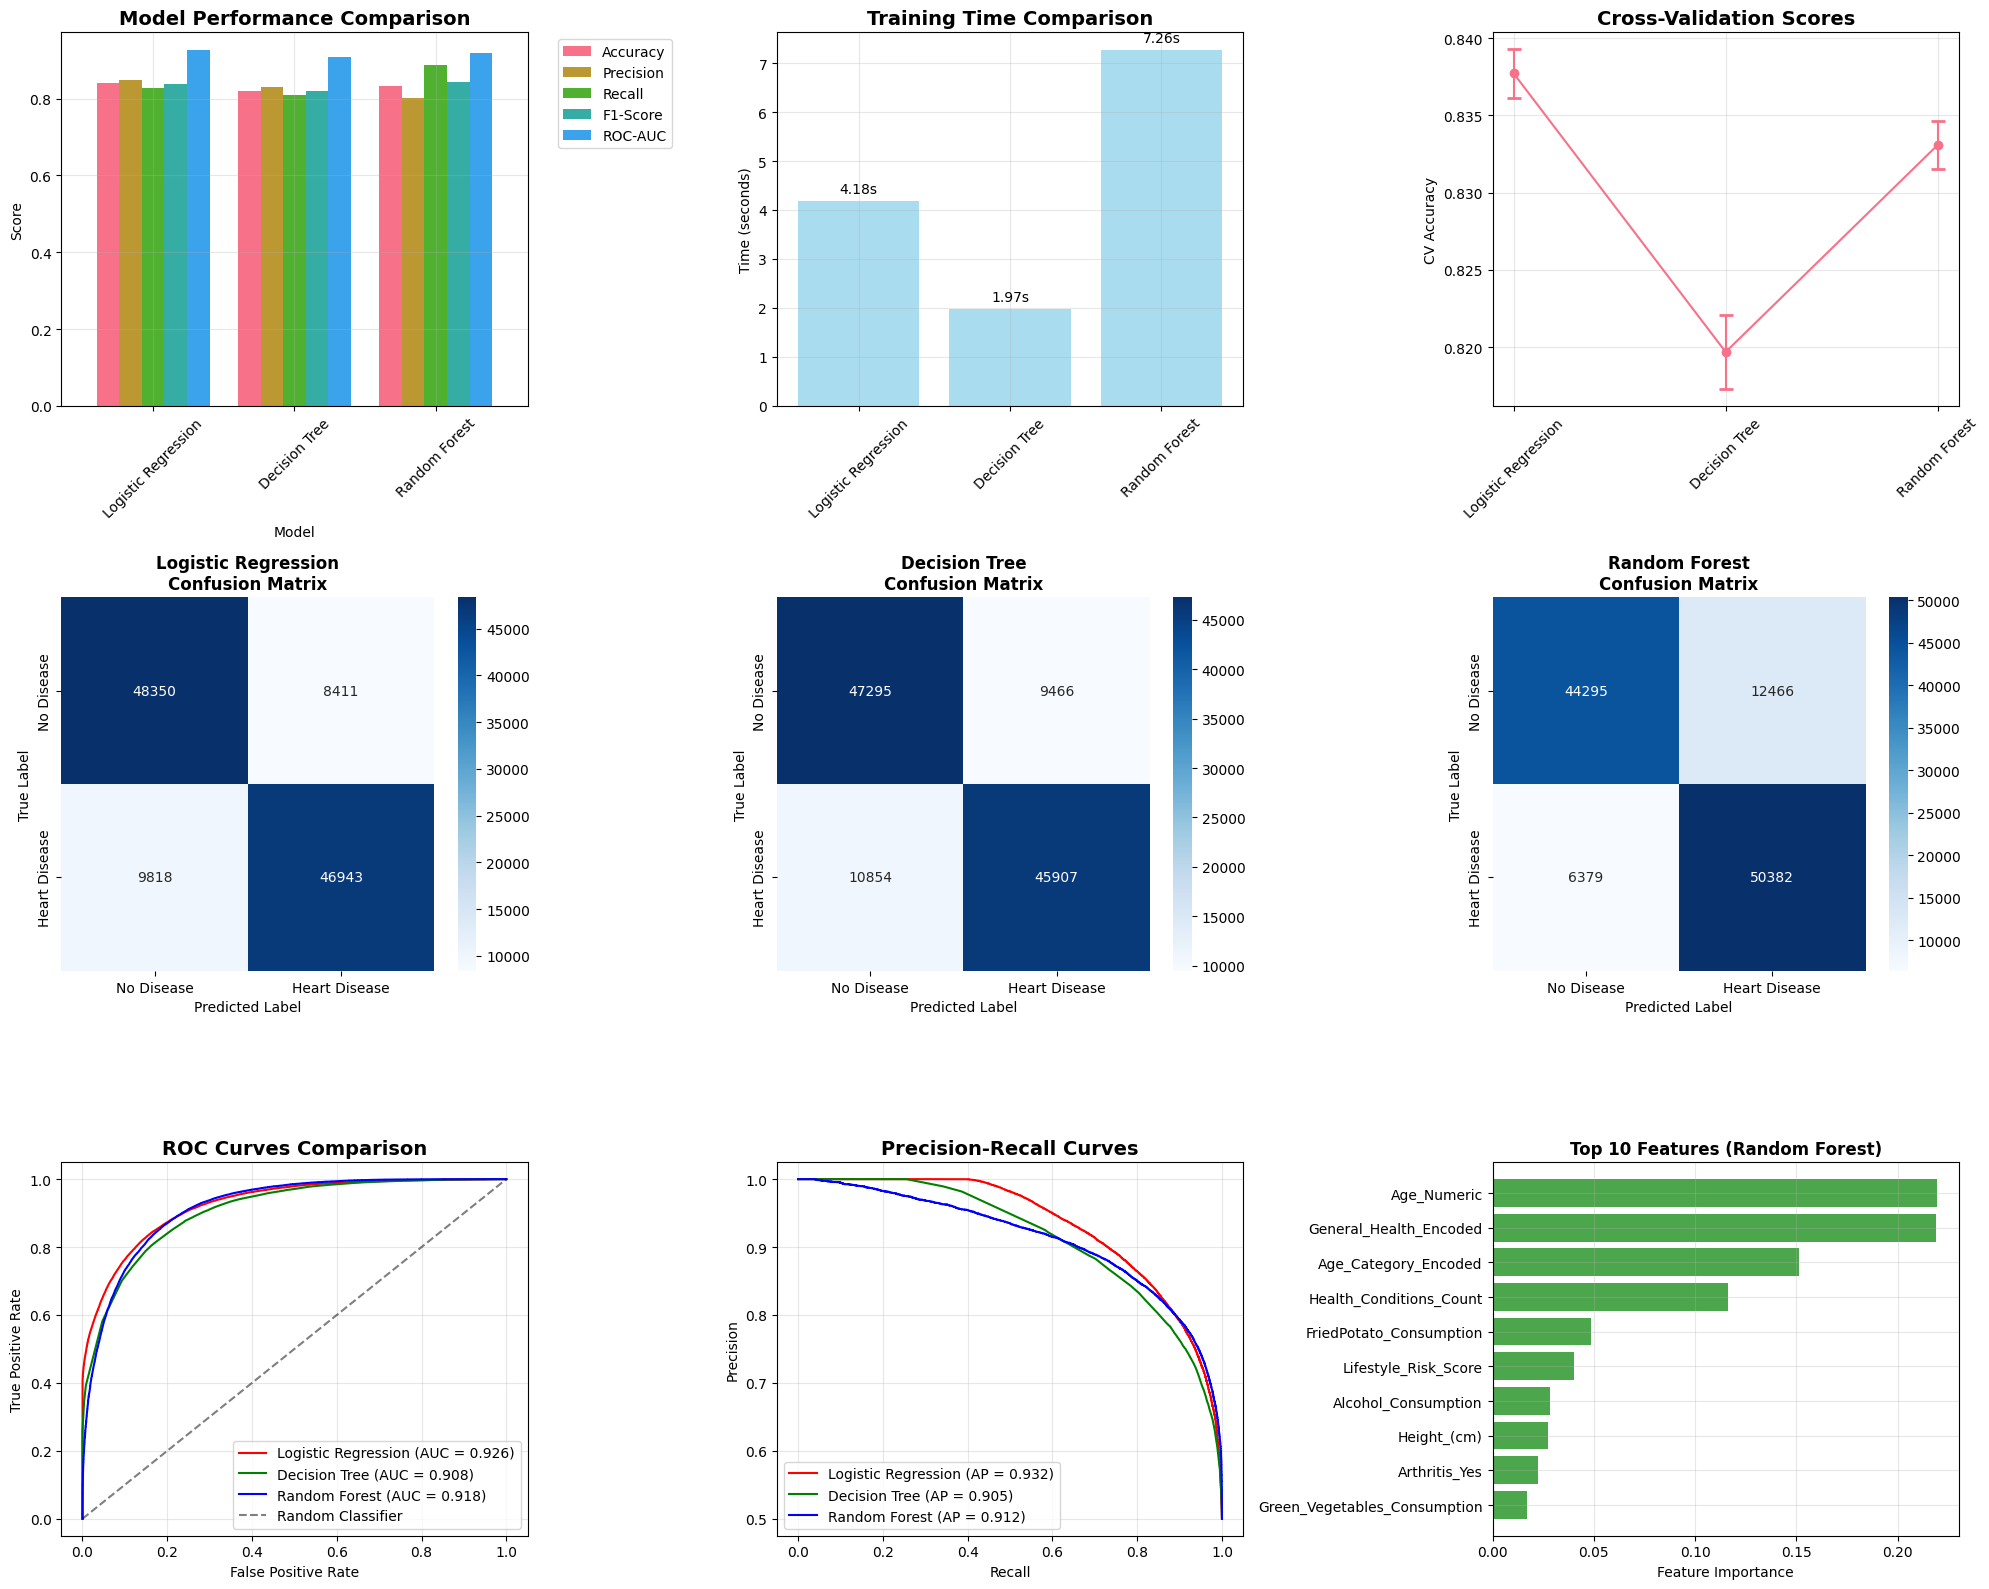

✅ Performance dashboard created successfully!


In [ ]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 16))

# 1. Performance Metrics Bar Chart
plt.subplot(3, 3, 1)
metrics_plot = results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_plot.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 2. Training Time Comparison
plt.subplot(3, 3, 2)
plt.bar(results_df['Model'], results_df['Training Time (s)'], color='skyblue', alpha=0.7)
plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
for i, v in enumerate(results_df['Training Time (s)']):
    plt.text(i, v + 0.1, f'{v:.2f}s', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# 3. Cross-Validation Scores with Error Bars
plt.subplot(3, 3, 3)
plt.errorbar(range(len(results_df)), results_df['CV Mean'], 
             yerr=results_df['CV Std'], fmt='o-', capsize=5, capthick=2)
plt.xticks(range(len(results_df)), results_df['Model'], rotation=45)
plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
plt.ylabel('CV Accuracy')
plt.grid(True, alpha=0.3)

# 4-6. Confusion Matrices
for i, (model_name, results) in enumerate(model_results.items()):
    plt.subplot(3, 3, 4 + i)
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Disease', 'Heart Disease'],
                yticklabels=['No Disease', 'Heart Disease'])
    plt.title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# 7. ROC Curves
plt.subplot(3, 3, 7)
colors = ['red', 'green', 'blue']
for i, (model_name, results) in enumerate(model_results.items()):
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    auc_score = results['roc_auc']
    plt.plot(fpr, tpr, color=colors[i], label=f'{model_name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Precision-Recall Curves
plt.subplot(3, 3, 8)
for i, (model_name, results) in enumerate(model_results.items()):
    precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
    avg_precision = average_precision_score(y_test, results['y_pred_proba'])
    plt.plot(recall, precision, color=colors[i], 
             label=f'{model_name} (AP = {avg_precision:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Feature Importance (Random Forest only)
plt.subplot(3, 3, 9)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    plt.barh(range(len(feature_importance)), feature_importance['importance'], color='green', alpha=0.7)
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Features (Random Forest)', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Feature Importance\nNot Available', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

## Save Models & Results

In [ ]:
# Save trained models and results
# Create models directory
models_dir = '../models/baseline_models'
os.makedirs(models_dir, exist_ok=True)

# Save each trained model
for model_name, model in trained_models.items():
    model_filename = f"{models_dir}/{model_name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(model, model_filename)

# Save results DataFrame
results_df.to_csv(f"{models_dir}/baseline_results.csv", index=False)

# Save detailed results with predictions
import json
detailed_results = {}
for model_name, results in model_results.items():
    detailed_results[model_name] = {
        'accuracy': float(results['accuracy']),
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'f1_score': float(results['f1_score']),
        'roc_auc': float(results['roc_auc']),
        'cv_mean': float(results['cv_mean']),
        'cv_std': float(results['cv_std']),
        'training_time': float(results['training_time'])
    }

with open(f"{models_dir}/detailed_results.json", 'w') as f:
    json.dump(detailed_results, f, indent=2)

# Create model summary report
report_content = f"""
# CardioFusion Baseline Models Report
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Dataset Information
- Training samples: {X_train.shape[0]:,}
- Testing samples: {X_test.shape[0]:,}
- Features: {X_train.shape[1]}
- Target balance: 50% No Disease, 50% Heart Disease (after SMOTE)

## Model Performance Summary
{results_df.round(4).to_string(index=False)}

## Best Performing Models
"""

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = results_df.loc[results_df[metric].idxmax(), 'Model']
    best_score = results_df[metric].max()
    report_content += f"\n- {metric}: {best_model} ({best_score:.4f})"

report_content += f"\n\n## Overall Best Model: {best_overall} (Based on F1-Score)"

with open(f"{models_dir}/baseline_models_report.md", 'w') as f:
    f.write(report_content)

💾 SAVING MODELS & RESULTS
✅ Saved Logistic Regression model: ../models/baseline_models/logistic_regression_model.pkl
✅ Saved Decision Tree model: ../models/baseline_models/decision_tree_model.pkl
✅ Saved Random Forest model: ../models/baseline_models/random_forest_model.pkl
✅ Saved performance results: ../models/baseline_models/baseline_results.csv
✅ Saved detailed results: ../models/baseline_models/detailed_results.json
✅ Saved model report: ../models/baseline_models/baseline_models_report.md

📁 All files saved in '../models/baseline_models' directory

✅ CardioFusion baseline models training completed successfully!
🚀 Ready for advanced model development and hyperparameter tuning!


## Next Steps & Recommendations

### Key Findings
- All baseline models have been trained and evaluated on the balanced CardioFusion dataset
- Performance metrics and visualizations provide comprehensive model comparison
- Models are saved and ready for production use or further optimization

### Recommended Next Steps
1. Hyperparameter Tuning: Use GridSearchCV or RandomizedSearchCV to optimize model parameters
2. Advanced Models: Implement XGBoost, LightGBM, or Neural Networks
3. Feature Engineering: Create additional features or apply feature selection
4. Ensemble Methods: Combine multiple models using voting or stacking
5. Model Interpretation: Use SHAP or LIME for explainable AI insights

### Production Considerations
- Monitor model performance on new data
- Implement model versioning and tracking
- Set up automated retraining pipelines
- Consider fairness and bias evaluation across demographic groups